In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join, pardir
import sys 
from glob import glob 
import vaex
from hammer import Model
current = abspath("")
root_dir = abspath(join(current, pardir))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

# simple model

In [2]:
from utils import concat, style

style()

In [3]:
root_data_dir = join(root_dir, 'Data')
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [4]:
baryon_dir = join(root_data_dir, "Baryon")
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#    components               rho     e_rho    sigma_z    e_sigma_z
0    Molecular gas (H2)       0.0104  0.00312  3.7        0.2
1    Cold atomic gas (HI(1))  0.0277  0.00554  7.1        0.5
2    Warm atomic gas (HI(2))  0.0073  0.0007   22.1       2.4
3    Hot ionized gas (HII)    0.0005  3e-05    39.0       4.0
4    Giant stars              0.0006  6e-05    15.5       1.6
...  ...                      ...     ...      ...        ...
7    4 < MV < 5               0.0029  0.00029  18.0       1.8
8    5 < MV < 8               0.0072  0.00072  18.5       1.9
9    MV > 8                   0.0216  0.0028   18.5       4.0
10   White dwarfs             0.0056  0.001    20.0       5.0
11   Brown dwarfs             0.0015  0.0005   20.0       5.0

In [5]:
from scipy.optimize import curve_fit
class model:
    def __init__(self, theta):
        self.theta = theta
    def fz_dm(self, z, rhoDM):
        self.theta[24] = rhoDM
        return Model.DM.fz(z, self.theta, dz=0.5)
    def fz_dddm(self, z, rhoDM, sigmaDD, hDD):
        self.theta[24] = rhoDM
        self.theta[25] = sigmaDD
        self.theta[26] = hDD
        return Model.DDDM.fz(z, self.theta, dz=0.5)
    def fz_no(self, z, alpha):
        self.theta[12:24] *= alpha
        return Model.NO.fz(z, self.theta, dz=0.5)

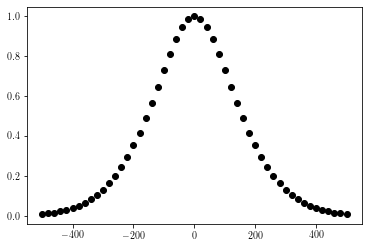

(array([1.2]), array([1.59999253e-02, 9.13686959e-05, 3.02153899e+02]))

In [30]:
rhob = np.array(df_baryon["rho"].to_numpy())  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
rhoDM = 0.016
sigmaDD = 7
hDD = 30
log_nu0 = 0
zsun = 0
R = 3.4E-3
w0 = -7
sigmaw1 = 5
sigmaw2 = 10
log_sigmaw = np.log(sigmaw1)
q_sigmaw = sigmaw1/sigmaw2
a1 = 1
a2 = 0.1
log_a = np.log(a1)
q_a = a2/a1

theta_dm = concat(sigmaz, rhob, rhoDM, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)
theta_dddm = concat(sigmaz, rhob, rhoDM, sigmaDD, hDD, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)
theta_no = concat(sigmaz, rhob, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a)

zs = np.arange(-500, 501, 20.0)
z = np.linspace(-500, 500, 100)
nuz = Model.DM.fz(zs, theta_dm, dz=0.5)
# noise = np.random.randn(len(zs))*0.01
# nuz += noise

plt.scatter(zs, nuz, c='k')
plt.show()

mask_pos = zs > 200
mask_neg = zs < -200
mask = ~(mask_pos | mask_neg)

fit_dm = curve_fit(model(theta_dm).fz_dm, zs[mask], nuz[mask], p0=[0.016])
fit_dddm, _ = curve_fit(model(theta_dddm).fz_dddm, zs[mask], nuz[mask], p0=[0.011, 1, 100], maxfev = 3000)
fit_no, _ = curve_fit(model(theta_no).fz_no, zs[mask], nuz[mask], p0=[1.2])
rhob_fit = rhob*fit_no[0]
fit_no, fit_dddm

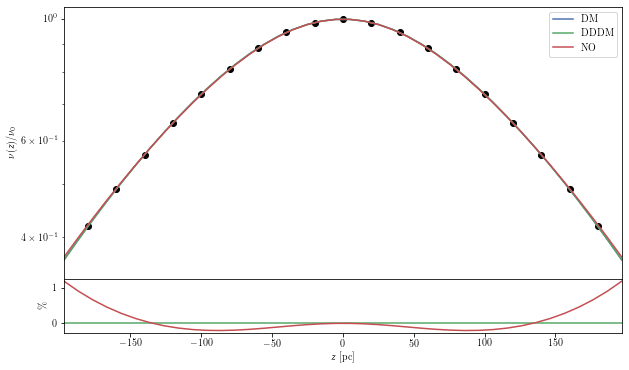

In [31]:
theta_dm[24] = fit_dm[0]

theta_dddm[24] = fit_dddm[0]
theta_dddm[25] = fit_dddm[1]
theta_dddm[26] = fit_dddm[2]

theta_no[12:24] = rhob_fit

nuz_dm = Model.DM.fz(z, theta_dm, dz=0.5)
nuz_dddm = Model.DDDM.fz(z, theta_dddm, dz=0.5)
nuz_no = Model.NO.fz(z, theta_no, dz=0.5)

mask_z_pos = z > 200
mask_z_neg = z < -200
mask_z = ~(mask_z_pos | mask_z_neg)
mask_z

# add fig_kw for height ratio 5:1
fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
plt.subplots_adjust(hspace=0)
axes[0].scatter(zs[mask], nuz[mask], c='k')
axes[0].plot(z[mask_z], nuz_dm[mask_z], label="DM", c='C0')
axes[0].plot(z[mask_z], nuz_dddm[mask_z], label="DDDM", c='C1')
axes[0].plot(z[mask_z], nuz_no[mask_z], label="NO", c='C2')
axes[0].set_yscale('log')
axes[0].set_ylabel(r'$\nu(z)/\nu_0$')
axes[0].legend()
axes[1].plot(z[mask_z], (nuz_dddm[mask_z]-nuz_dm[mask_z])/nuz_dm[mask_z]*100, label="DDDM", c='C1')
axes[1].plot(z[mask_z], (nuz_no[mask_z]-nuz_dm[mask_z])/nuz_dm[mask_z]*100, label="NO", c='C2')
axes[1].set_ylabel('\%')
axes[1].set_xlabel(r'$z$ [pc]')
axes[1].set_xlim(z[mask_z].min(), z[mask_z].max())
fig.savefig(join("img", "compare-1.pdf"), dpi=70)
plt.show()

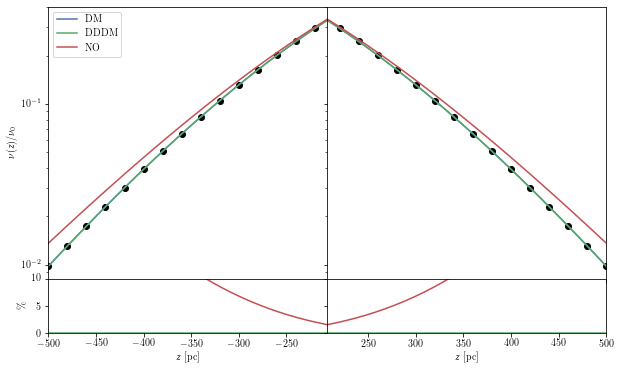

In [33]:
# add fig_kw for height ratio 5:1
fig, axes = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [5, 1]}, sharex='col', sharey='row')
plt.subplots_adjust(wspace=0, hspace=0)
# left
axes[0, 0].scatter(zs[mask_neg], nuz[mask_neg], c='k')
axes[0, 0].plot(z[mask_z_neg], nuz_dm[mask_z_neg], label="DM", c='C0')
axes[0, 0].plot(z[mask_z_neg], nuz_dddm[mask_z_neg], label="DDDM", c='C1')
axes[0, 0].plot(z[mask_z_neg], nuz_no[mask_z_neg], label="NO", c='C2')
axes[0, 0].set_yscale('log')
axes[0, 0].set_ylabel(r'$\nu(z)/\nu_0$')
axes[0, 0].legend()
axes[1, 0].plot(z[mask_z_neg], (nuz_dddm[mask_z_neg]-nuz_dm[mask_z_neg])/nuz_dm[mask_z_neg]*100, label="DDDM", c='C1')
axes[1, 0].plot(z[mask_z_neg], (nuz_no[mask_z_neg]-nuz_dm[mask_z_neg])/nuz_dm[mask_z_neg]*100, label="DDDM", c='C2')
axes[1, 0].set_xlim(z[mask_z_neg].min(), z[mask_z_neg].max())
axes[1, 0].set_ylabel('\%')
axes[1, 0].set_xlabel(r'$z$ [pc]')
# right
axes[0, 1].scatter(zs[mask_pos], nuz[mask_pos], c='k')
axes[0, 1].plot(z[mask_z_pos], nuz_dm[mask_z_pos], label="DM", c='C0')
axes[0, 1].plot(z[mask_z_pos], nuz_dddm[mask_z_pos], label="DDDM", c='C1')
axes[0, 1].plot(z[mask_z_pos], nuz_no[mask_z_pos], label="NO", c='C2')
axes[0, 1].set_yscale('log')
axes[1, 1].plot(z[mask_z_pos], (nuz_dddm[mask_z_pos]-nuz_dm[mask_z_pos])/nuz_dm[mask_z_pos]*100, label="DDDM", c='C1')
axes[1, 1].plot(z[mask_z_pos], (nuz_no[mask_z_pos]-nuz_dm[mask_z_pos])/nuz_dm[mask_z_pos]*100, label="DDDM", c='C2')
axes[1, 1].set_xlim(z[mask_z_pos].min(), z[mask_z_pos].max())
axes[1, 1].set_ylim(0, 10)
axes[1, 1].set_xlabel(r'$z$ [pc]')
# fig.savefig(join("img", "compare-2.pdf"), dpi=70)
plt.show()

# The Model

In [2]:
from utils import (style, get_params, concat, get_initial_position_normal, 
                    get_data_z, get_data_w, generate_init, hdi)

style()

In [3]:
z_dir_path = join(root_data_dir, 'MCMC-mock', 'thin')
w_dir_path = join(root_data_dir, 'MCMC-mock', 'thin')
z_dir_path, w_dir_path

('/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin',
 '/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin')

In [29]:
# z_dir_path = join(root_data_dir, 'Effective-Volume', 'no')
# w_dir_path = join(root_data_dir, 'Velocity-Distribution', 'no')
# z_dir_path, w_dir_path

In [4]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
rhob = np.array(df_baryon["rho"].to_numpy())  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
e_rhob = np.array(df_baryon["e_rho"].to_numpy())  # Msun/pc^3
e_sigmaz = np.array(df_baryon["e_sigma_z"].to_numpy())  # km/s
df_baryon

#    components               rho     e_rho    sigma_z    e_sigma_z
0    Molecular gas (H2)       0.0104  0.00312  3.7        0.2
1    Cold atomic gas (HI(1))  0.0277  0.00554  7.1        0.5
2    Warm atomic gas (HI(2))  0.0073  0.0007   22.1       2.4
3    Hot ionized gas (HII)    0.0005  3e-05    39.0       4.0
4    Giant stars              0.0006  6e-05    15.5       1.6
...  ...                      ...     ...      ...        ...
7    4 < MV < 5               0.0029  0.00029  18.0       1.8
8    5 < MV < 8               0.0072  0.00072  18.5       1.9
9    MV > 8                   0.0216  0.0028   18.5       4.0
10   White dwarfs             0.0056  0.001    20.0       5.0
11   Brown dwarfs             0.0015  0.0005   20.0       5.0

In [6]:
# rhob_mean = df_baryon['rho'].to_numpy()
# rhob_err = df_baryon['e_rho'].to_numpy()
# sigmaz_mean = df_baryon['sigma_z'].to_numpy()
# sigmaz_err = df_baryon['e_sigma_z'].to_numpy()

In [5]:
index = 1
z_files = glob(join(z_dir_path, "z*"))
z_files.sort()
w_files = glob(join(w_dir_path, "w*"))
w_files.sort()
z_files, w_files

(['/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/z_0001000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/z_0010000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/z_0100000.hdf5'],
 ['/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/w_0001000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/w_0010000.hdf5',
  '/home2/s20321005/Thesis-Project/Data/MCMC-mock/thin/w_0100000.hdf5'])

In [8]:
# # Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
# rhob = np.array(df_baryon["rho"].to_numpy())  # Msun/pc^3
# sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# baryon = concat(rhob, sigmaz)

# beta = 1
# alpha = 1
# rhoDM = 0.016
# log_nu0 = 0
# zsun = 30
# R = 3.4E-3
# w0 = -7
# sigmaw1 = 5
# sigmaw2 = 10
# log_sigmaw = np.log(sigmaw1)
# q_sigmaw = sigmaw1/sigmaw2
# a1 = 1
# a2 = 0.1
# log_a = np.log(a1)
# q_a = a2/a1
# log_phi = 2

# theta = concat(beta, alpha, rhoDM, log_nu0, zsun, R, w0, log_sigmaw, q_sigmaw, log_a, q_a, log_phi)
# log_phi = np.log(Model.DM.potential(np.array([50.+zsun]), theta, baryon, 1.0))
# theta[-1] = log_phi
# # # integration limits
# # z_start = 0
# # z_end = 200
# baryon.shape, theta.shape

# run_mcmc

In [44]:
from tqdm import tqdm
from hammer import Model
from typing import Tuple
from time import time
from utils import generate_init, get_initial_position_normal
def mcmc(
        model: Model, 
        zdata: Tuple[np.ndarray, np.ndarray], 
        wdata: Tuple[np.ndarray, np.ndarray],
        **options):
    """
    Run MCMC

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` \n
    zdata: `Tuple[np.ndarray, np.ndarray]` = (zmid, znum) \n
    wdata: `Tuple[np.ndarray, np.ndarray]` = (wmid, wnum) \n
    baryon: `np.ndarray` = [...rhob, ...sigmaz] \n
    
    options:
        step0: `int` = 500 \n
        step: `int` = 2000 \n
        burn: `int` = 1000 \n
        it: `int` = 3 \n
        thin: `int` = 20 \n
        verbose: `bool` = True \n
        m: `int` = 10 (multiplier, `nwalker = m*ndim`)
        
    Returns
    -------
    result: `dict` = { \n
        indexes: `ndarray(shape(nparam))`, \n
        labs: `ndarray(shape(nparam))`, \n
        labels: `ndarray(shape(nparam))`, \n
        chain: `ndarray(shape(nstep,nwalker,nparam))` \n
    }
    """
    step0 = options.get("step0", 100)
    step = options.get("step", 2000)
    burn = options.get("burn", 1000)
    it = options.get("it", 3)
    thin = options.get("thin", 20)
    verbose = options.get("verbose", True)
    m = options.get("m", 10)
    if verbose: print("running...")
    log_nu0_max = np.log(zdata[1].max())
    log_a_max = np.log(wdata[1].max())
    init = generate_init(model, log_nu0_max, log_a_max)
    locs = init['locs']
    scales = init['scales']    
    indexes = init['indexes']
    labs = init['labs']
    labels = init['labels']
    # print(locs, scales)
    # raise NotImplementedError()
    ndim = len(locs)
    nwalker = m*ndim
    if verbose: print(f"mcmc...")
    p0 = model.generate_p0(nwalker*2, locs, scales)
    prob = model.log_prob_par(p0, zdata, wdata, locs, scales)
    mask = np.isinf(prob[:, 0])
    p0 = p0[~mask]
    if len(p0) % 2 != 0:
        p0 = p0[:-1]
    print(p0.shape)
    for i in tqdm(range(it), desc="mcmc"):
        t0 = time()
        chain = model.mcmc(step0, p0, zdata, wdata, locs, scales,  parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: first half mcmc done {np.round(t1-t0, 2)} s")
        locs_normal, scales_normal = get_initial_position_normal(model, log_nu0_max, log_a_max, chain=chain[int(step0/2):])
        p0 = model.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
        t0 = time()
        chain = model.mcmc(step0, p0, zdata, wdata, locs, scales,  parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: second half mcmc done {np.round(t1-t0, 2)} s")
        p0 = chain[-1]
        prob = model.log_prob_par(p0, zdata, wdata, locs, scales)
        mask = np.isinf(prob[:, 0])
        p0 = p0[~mask]
        if len(p0) % 2 != 0:
            p0 = p0[:-1]
    t0 = time()
    chain = model.mcmc(burn, p0, zdata, wdata, locs, scales,  parallel=True, verbose=verbose)
    t1 = time()
    if verbose: print(f"burn done {np.round(t1-t0, 2)} s")
    p0 = chain[-1]
    t0 = time()
    chain = model.mcmc(step, p0, zdata, wdata, locs, scales,  parallel=True, verbose=verbose)
    t1 = time()
    if verbose: print(f"mcmc done {np.round(t1-t0, 2)} s")
    chain_thin = chain[::thin]
    return {
        "indexes": indexes,
        "labs": labs,
        "labels": labels,
        "chain": chain_thin
        }

In [6]:
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")
zdata_ori = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata_ori
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]

zdata = (zmid, znum, comp)
zdata, wdata

((array([-190., -170., -150., -130., -110.,  -90.,  -70.,  -50.,  -30.,
          -10.,   10.,   30.,   50.,   70.,   90.,  110.,  130.,  150.,
          170.,  190.]),
  array([ 78.62632032, 114.11070853, 174.48366831, 252.28797405,
         367.83340297, 525.52917705, 686.4774589 , 811.94566618,
         939.77720892, 862.24523218, 801.29008825, 759.46859047,
         618.47936729, 518.38754126, 384.67487684, 257.70904674,
         185.43852902, 119.57947401,  81.44000775,  56.91966747]),
  array([0.48237006, 0.47348842, 0.46528978, 0.45787291, 0.45132933,
         0.44574146, 0.44118089, 0.43770656, 0.4344786 , 0.38579205,
         0.38579205, 0.4344786 , 0.43770656, 0.44118089, 0.44574146,
         0.45132933, 0.45787291, 0.46528978, 0.47348842, 0.48237006])),
 (array([-36.17501677, -34.02678564, -31.8785545 , -29.73032337,
         -27.58209224, -25.4338611 , -23.28562997, -21.13739884,
         -18.9891677 , -16.84093657, -14.69270544, -12.5444743 ,
         -10.39624317,  -8.248

In [46]:
model = Model.DM
result = mcmc(
    model=model,
    zdata=zdata,
    wdata=wdata,
    step0=500,
    step=500,
    burn=500,
    it=1,
    thin=5,
    m=10
)

result.keys()

running...
mcmc...
(302, 33)


mcmc:   0%|          | 0/1 [00:00<?, ?it/s]

0: first half mcmc done 10.91 s


mcmc: 100%|██████████| 1/1 [00:22<00:00, 22.80s/it]

0: second half mcmc done 11.83 s
burn done 11.68 s
mcmc done 11.58 s

dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [47]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels_raw = result['labels']
step, nwalker, ndim = chain_thin.shape
step, nwalker, ndim

(100, 330, 33)

# plot_chain

 18%|█▊        | 2/11 [00:00<00:01,  5.94it/s]

100%|██████████| 11/11 [00:01<00:00,  8.10it/s]


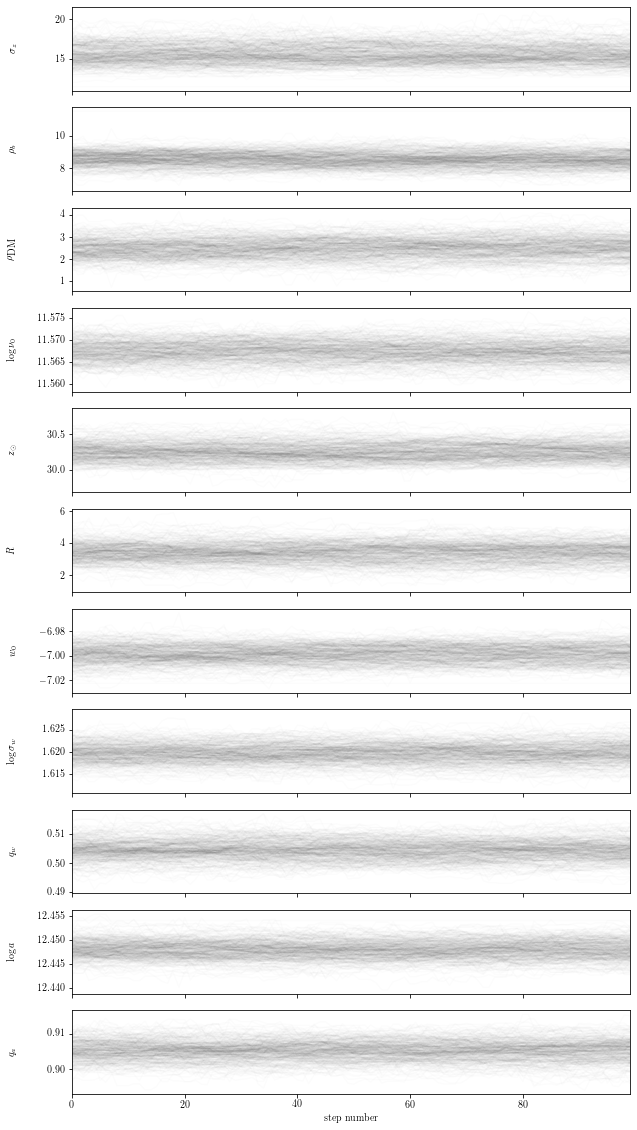

In [48]:
from utils import plot_chain, get_params

params, labels = get_params(chain_thin, indexes, labs, labels_raw)

# labels.shape
plot_chain(
    params=params,
    labels=labels,
    alpha=0.01,
    figsize=(10, 20),
)

In [13]:
# log_nu0_max = np.log(zdata[1].max())
# log_a_max = np.log(wdata[1].max())
# locs_normal, scales_normal = get_initial_position_normal(Model.DM, log_nu0_max, log_a_max, chain=chain_thin[200:])
# p0 = Model.DM.generate_p0(nwalker, locs_normal, scales_normal, norm=True)

# plt.hist(p0[:, -1], bins=100);

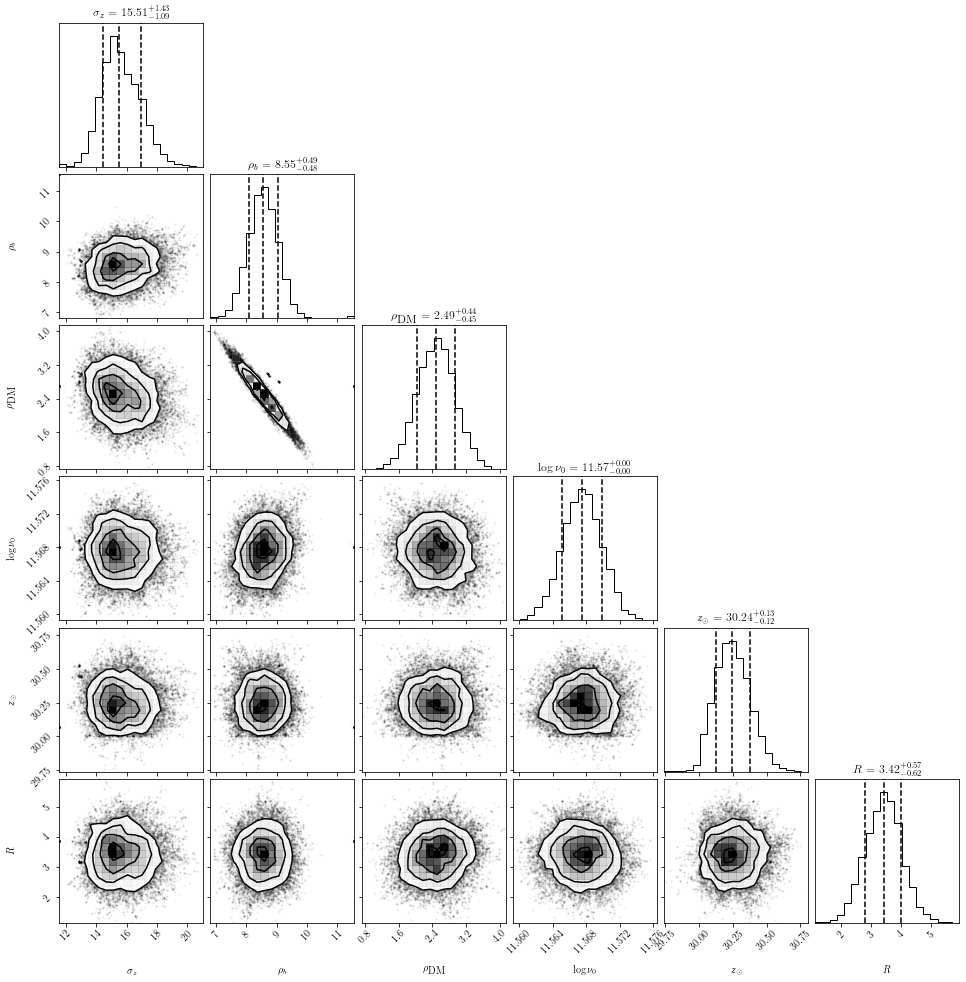

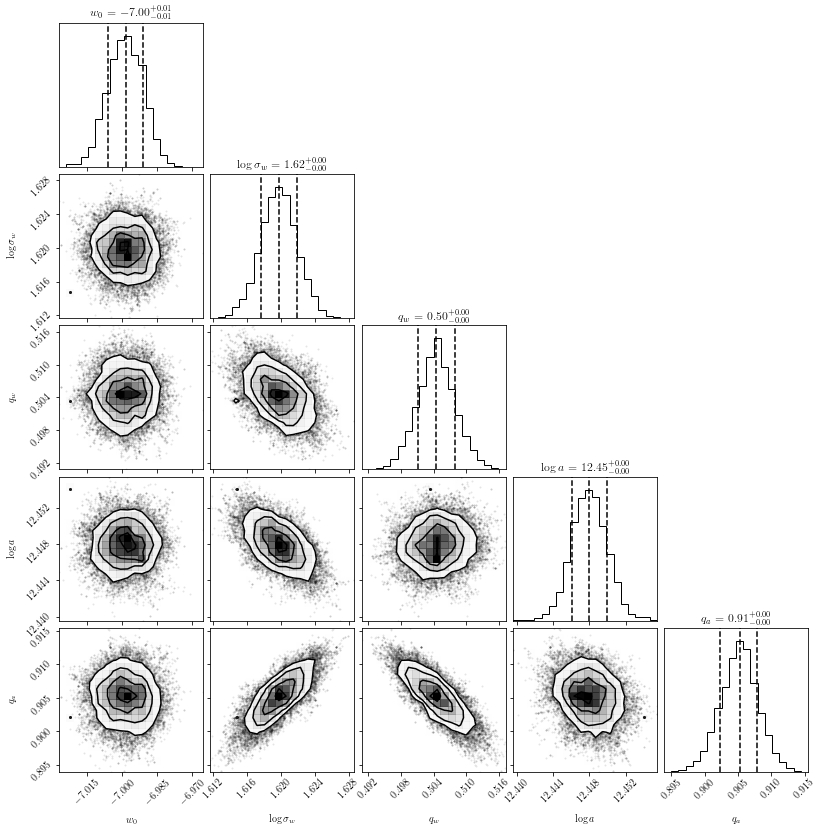

In [49]:
from utils import plot_corner

bs = {
    Model.DM.name: 6,
    Model.DDDM.name: 8,
    Model.NO.name: 5
}

b = bs[model.name]

# z
plot_corner(
    params=params[:, :, :b],
    labels=labels[:b],
)

# w
plot_corner(
    params=params[:, :, b:],
    labels=labels[b:],
)

# plot_fit

In [50]:
from hammer import Model
from typing import Tuple

def plot_fit(
        model: Model, 
        flat_chain: np.ndarray, 
        zdata: Tuple[np.ndarray, np.ndarray, np.ndarray], 
        wdata: Tuple[np.ndarray, np.ndarray], 
        **options: dict):
    """required: 
            model: `Model` = Model.DM \n
            flat_chain: `ndarray(shape=(nsample, nparam))`\n
            zdata: `Tuple[np.ndarray, np.ndarray]` \n
            wdata: `Tuple[np.ndarray, np.ndarray]` \n
            baryon: `ndarray` = [...rhob, ...sigmaz] \n
        options:
            res: `int` = 100 \n
            nsample: `int` = 5_000 \n
            figsize: `Tuple[int, int]` = (10, 10) \n
            alpha: `float` = 0.1 \n
            c: `str` = C0 \n
            log: `bool` = False \n
            dpi: `int` = 70 \n
            path: `str` = None \n
            fig_kw: `Dict` = All additional keyword arguments for `.pyplot.figure`.
            """
    res = options.get('res', 100)
    nsample = options.get('nsample', 5_000)
    figsize = options.get('figsize', (10, 10))
    alpha = options.get('alpha', 0.05)
    c = options.get('c', "C0")
    log = options.get('log', False)
    dpi = options.get('dpi', 70)
    path = options.get('path', None)
    fig_kw  = options.get('fig_kw', {})

    ind = np.random.choice(np.arange(len(flat_chain)), size=nsample, replace=False)
    theta = flat_chain[ind]
    sigma = np.array([68, 90, 95])
    alpha = 1 - sigma/100

    fit = model.fit_data(theta, zdata, wdata, alpha, res=res)
    zmid = zdata[0]
    wmid = wdata[0]
    zs, ws = fit['b']
    zest = fit['zest']
    west = fit['west']
    zmod = fit['zmod']
    wmod = fit['wmod']
    fig, axes = plt.subplots(2, 1, figsize=figsize, **fig_kw)
    for ax, xlabel, ylabel, mid, est, mod, xs in zip(axes, [r"$z$ [pc]", r"$w$ [km/s]"], [r"$\nu(z)/\nu_0$", r"$f_0(w)$"], [zmid, wmid], [zest, west], [zmod, wmod], [zs, ws]):
        mod_mode = mod[3]
        max = mod_mode.max()
        mod /= max
        mod_lows = mod[:3]
        mod_highs = mod[4:]
        mod_highs = mod_highs[::-1]
        est /= max
        est_mode = est[3]
        est_lows = est[:3]
        est_highs = est[4:]
        est_highs = est_highs[::-1]
        ax.plot(xs, mod_mode, c=c, ls='--')
        for est_low, est_high, mod_low, mod_high in zip(est_lows, est_highs, mod_lows, mod_highs):
            ax.errorbar(mid, est_mode, yerr=(est_mode-est_low, est_high-est_mode), fmt='.', capsize=2, c='k', alpha=0.5)
            ax.fill_between(xs, mod_high, mod_low, alpha=alpha, color=c)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if log:
            ax.set_ylim(mod_lows[0].min(), mod_highs[0].max()*1.5)
            ax.set_yscale("log")
        else:
            ax.set_ylim(0)
        ax.set_xlim(xs.min(), xs.max())
    if path is not None:
        fig.savefig(path, dpi=dpi)
    plt.show()

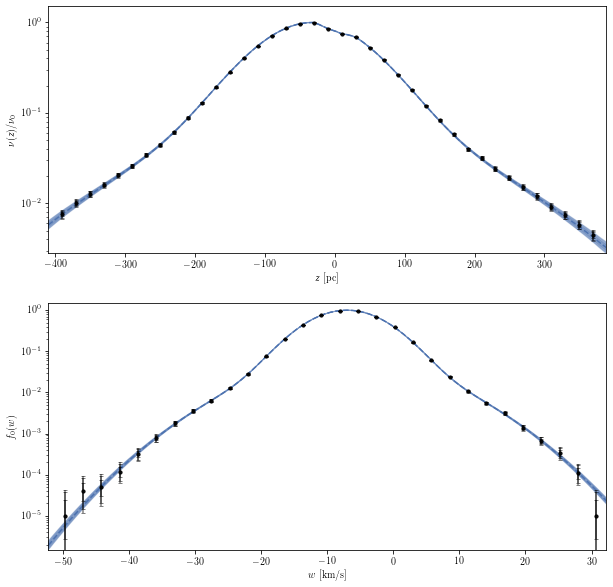

In [52]:
ndim = chain_thin.shape[-1]
flat_chain = chain_thin.reshape(-1, ndim)

zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid = zdata[0]
mask = np.abs(zmid) < 400
zdata = zdata[0][mask], zdata[1][mask], zdata[2][mask]


plot_fit(
    model=model,
    flat_chain=flat_chain,
    zdata=zdata,
    wdata=wdata,
    log=True,
    nsample=20_000
)

# Posterior predictive distribution

In [24]:
from datetime import datetime
from typing import Tuple
from scipy.stats import norm

def predictive_posterior(
        model: Model, 
        flat_chain: np.ndarray, 
        zdata: Tuple[np.ndarray, np.ndarray], 
        **options: dict
    ):
    """
    Calculate the predictive posterior of new data

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` \n
    flat_chain: ndarray(shape=(length, ndim)) \n
    zdata: ndarray = (zmid, znum, zerr) \n
    baryon: ndarray = [...rhob, ...sigmaz] \n
    options:
        nsample: `int` = 10_000 \n
        verbose: `bool` = True \n
        batch: `int` = 1000 \n
    """
    nsample = options.get("nsample", 20_000)
    verbose = options.get("verbose", True)
    # batch = options.get("batch", 1000)
    length, _ = flat_chain.shape
    if verbose: print("Calculating...")
    inds = np.random.choice(np.arange(length), size=nsample, replace=False)
    theta = flat_chain[inds]
    prob = model.predictive_posterior(theta, zdata, batch=100)
    return prob

In [25]:
flat_chain = chain_thin.reshape(-1, ndim)
nsample = flat_chain.shape[0]
ndim = chain_thin.shape[-1]
zdata = get_data_z(z_files[index])
zmid, znum, comp = zdata
mask = (np.abs(zmid) > 150)*(np.abs(zmid) < 200)
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

probs = predictive_posterior(
    model=model,
    flat_chain=flat_chain,
    zdata=zdata,
    nsample=nsample
)
probs.sum()

Calculating...


-14.568441460838201

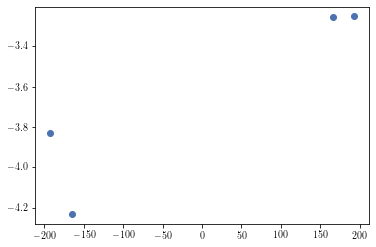

In [26]:
plt.scatter(zdata[0], probs)

In [49]:
def bayes_factor(
        model: Model, 
        flat_chain: np.ndarray, 
        zdata: Tuple[np.ndarray, np.ndarray, np.ndarray],
        wdata:Tuple[np.ndarray, np.ndarray],
        **options: dict
    ):
    """
    Calculate the bayes factor of the model
    """
    nsample = options.get("nsample", 5_000)
    alpha = options.get("alpha", 5)
    batch = options.get("batch", 10)
    run = options.get("run", 10)
    
    length, ndim = flat_chain.shape
    res = []
    for i in tqdm(range(run)):
        ind = np.random.choice(np.arange(length), size=nsample)
        theta = flat_chain[ind]
        vol = 1
        for i in range(ndim):
            l, u = np.percentile(theta[:, i], [alpha/2, 100-alpha/2])
            mask = (theta[:, i] > l)*(theta[:, i] < u)
            theta = theta[mask]
            vol *= u-l
        # print(theta.shape)
        log_nu0_max = np.log(zdata[1].max())
        log_a_max = np.log(wdata[1].max())
        init = generate_init(model, log_nu0_max, log_a_max)
        locs = init['locs']
        scales = init['scales']    
        log_prob = -1*model.log_prob_par(theta, zdata, wdata, locs, scales, batch=batch)
        log_max = np.max(log_prob)
        log_prob -= log_max
        log_sum = log_max + np.log(np.sum(np.exp(log_prob)))
        logZ = np.log(vol) - log_sum
        res.append(logZ*np.log10(np.e))
    return np.mean(res), np.std(res)

In [50]:
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) < 150
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

log_bf = bayes_factor(
    model=model, 
    flat_chain=flat_chain, 
    zdata=zdata,
    wdata=wdata,
    nsample=flat_chain.shape[0]*2,
    batch=10
)
log_bf

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


(-76.14529630627447, 0.06920660728381214)

# Script

do mcmc for

* same $N$, different $z$
* same $z$, different $N$

Each 'running' contains
1. generate_init: initial position for walkers.
    * this is done by the experiment above.
2. run_mcmc: run true mcmc for 10_000 steps.
3. plot trace: plot trace plot for preliminary mcmc.
4. plot corner: plot corner plot for the long run.
5. plot fit: fitting plot for vertical density and vertical dispersion.
6. calculate bic & aic: calculate bic and aic for the long run.

All of these functionalities are implemented in `mcmc.py` at `utils`.

Just run the `program.py` at `script`.
To automate the process for all data, run `run_program.py` at `script`.

# test utils

In [1]:
from os.path import abspath, join
from glob import glob
import vaex
from matplotlib import pyplot as plt
import sys
import numpy as np
current = abspath("")
root_dir = abspath(join(current, '..'))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

In [2]:
from utils import (style, get_params, mcmc, concat, predictive_posterior, bayes_factor,
                   plot_chain, plot_corner, plot_fit, get_data_z, get_data_w, Model)

style()

In [3]:
# z_dir_path = join(root_data_dir, 'MCMC-mock', 'thin')
# w_dir_path = join(root_data_dir, 'MCMC-mock', 'thin')
z_dir_path = join(root_data_dir, 'Vertical-Number', 'no')
w_dir_path = join(root_data_dir, 'Velocity-Distribution', 'no')
z_dir_path, w_dir_path

('/home2/s20321005/Thesis-Project/Data/Vertical-Number/no',
 '/home2/s20321005/Thesis-Project/Data/Velocity-Distribution/no')

In [4]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
rhob = np.array(df_baryon["rho"].to_numpy())  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
e_rhob = np.array(df_baryon["e_rho"].to_numpy())  # Msun/pc^3
e_sigmaz = np.array(df_baryon["e_sigma_z"].to_numpy())  # km/s
baryon = np.array([concat(rhob, sigmaz), concat(e_rhob, e_sigmaz)])
print(baryon.shape)
df_baryon

(2, 24)


#    components               rho     e_rho    sigma_z    e_sigma_z
0    Molecular gas (H2)       0.0104  0.00312  3.7        0.2
1    Cold atomic gas (HI(1))  0.0277  0.00554  7.1        0.5
2    Warm atomic gas (HI(2))  0.0073  0.0007   22.1       2.4
3    Hot ionized gas (HII)    0.0005  3e-05    39.0       4.0
4    Giant stars              0.0006  6e-05    15.5       1.6
...  ...                      ...     ...      ...        ...
7    4 < MV < 5               0.0029  0.00029  18.0       1.8
8    5 < MV < 8               0.0072  0.00072  18.5       1.9
9    MV > 8                   0.0216  0.0028   18.5       4.0
10   White dwarfs             0.0056  0.001    20.0       5.0
11   Brown dwarfs             0.0015  0.0005   20.0       5.0

In [5]:
index = 5
z_files = glob(join(z_dir_path, "z*"))
z_files.sort()
w_files = glob(join(w_dir_path, "w*"))
w_files.sort()
z_files, w_files

(['/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(-0.019)_(0.127).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.127)_(0.190).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.190)_(0.220).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.220)_(0.242).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.242)_(0.260).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.260)_(0.276).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.276)_(0.289).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.289)_(0.301).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.301)_(0.313).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.313)_(0.325).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.325)_(0.335).hdf5',
  '/home2/s20321005/Thesis-Project/Data/Vertical-Number/no/z_(0.335)_(0.345

In [6]:
print(mcmc.__doc__)


    Run MCMC

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` 

    zdata: `Tuple[np.ndarray, np.ndarray]` = (zmid, znum) 

    wdata: `Tuple[np.ndarray, np.ndarray]` = (wmid, wnum) 

    baryon: `np.ndarray` = [...rhob, ...sigmaz] 

    
    options:
        step0: `int` = 500 

        step: `int` = 2000 

        burn: `int` = 1000 

        it: `int` = 3 

        thin: `int` = 20 

        verbose: `bool` = True 

        m: `int` = 10 (multiplier, `nwalker = m*ndim`)
        
    Returns
    -------
    result: `dict` = { 

        indexes: `ndarray(shape(nparam))`, 

        labs: `ndarray(shape(nparam))`, 

        labels: `ndarray(shape(nparam))`, 

        chain: `ndarray(shape(nstep,nwalker,nparam))` 

    }
    


# DM

In [7]:
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")
zdata_ori = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata_ori
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)
model = Model.DM
result = mcmc(
    model=model,
    zdata=zdata,
    wdata=wdata,
    step0=500,
    step=1000,
    burn=500,
    it=2,
    thin=10,
    m=10
)

result.keys()

running...
mcmc...
(466, 33)


mcmc:   0%|          | 0/2 [00:00<?, ?it/s]

0: first half mcmc done 14.73 s


mcmc:  50%|█████     | 1/2 [00:26<00:26, 26.07s/it]

0: second half mcmc done 11.25 s
1: first half mcmc done 10.83 s


mcmc: 100%|██████████| 2/2 [00:48<00:00, 24.08s/it]

1: second half mcmc done 11.19 s
burn done 10.68 s


mcmc done 20.56 s


dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [8]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels_raw = result['labels']
step, nwalker, ndim = chain_thin.shape
step, nwalker, ndim

(100, 330, 33)

 64%|██████▎   | 7/11 [00:00<00:00,  8.41it/s]

100%|██████████| 11/11 [00:01<00:00,  7.81it/s]


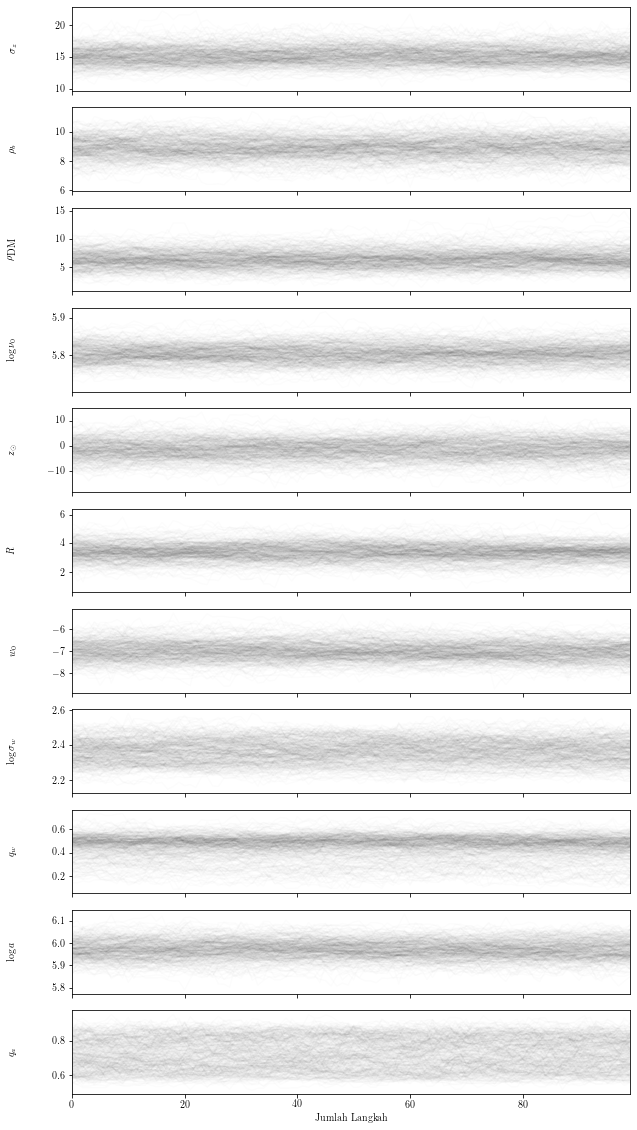

In [9]:
params, labels = get_params(chain_thin, indexes, labs, labels_raw)

plot_chain(
    params=params,
    labels=labels,
    alpha=0.01,
    figsize=(10, 20),
    # path=join("img", "chain-plot.pdf"), 
    dpi=70
)

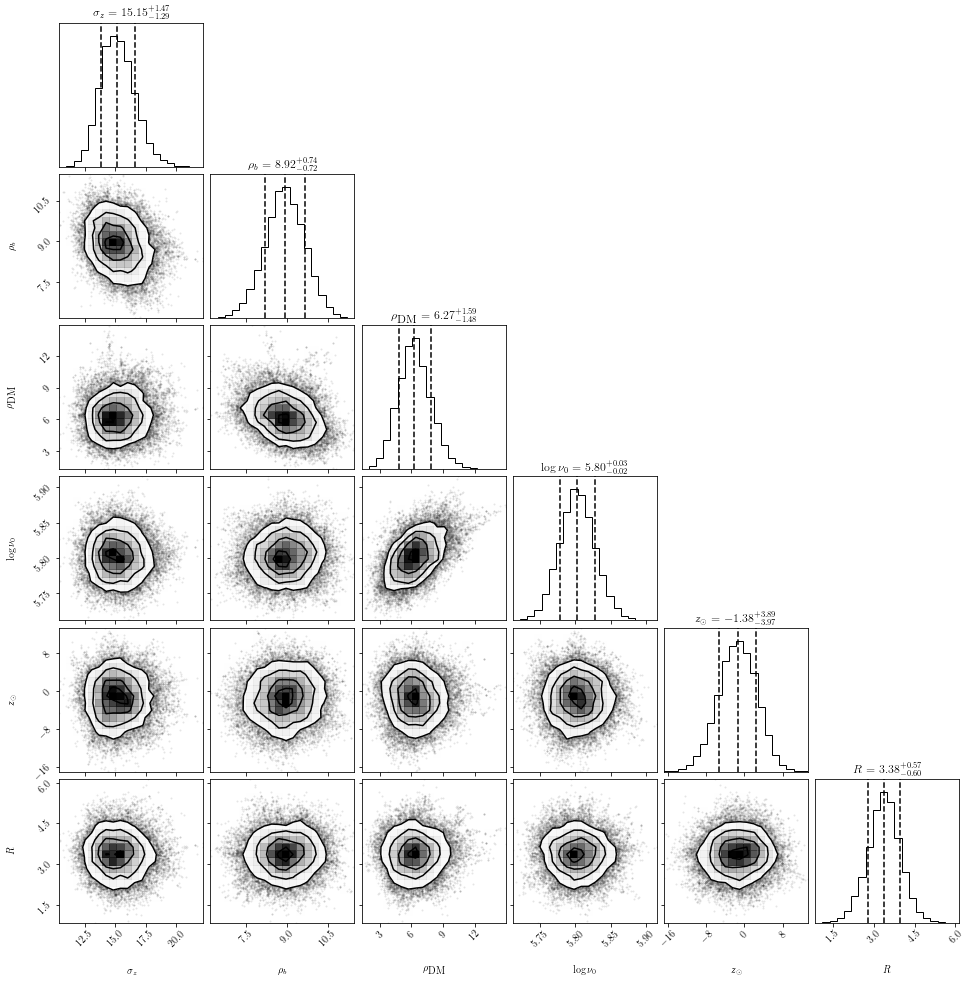

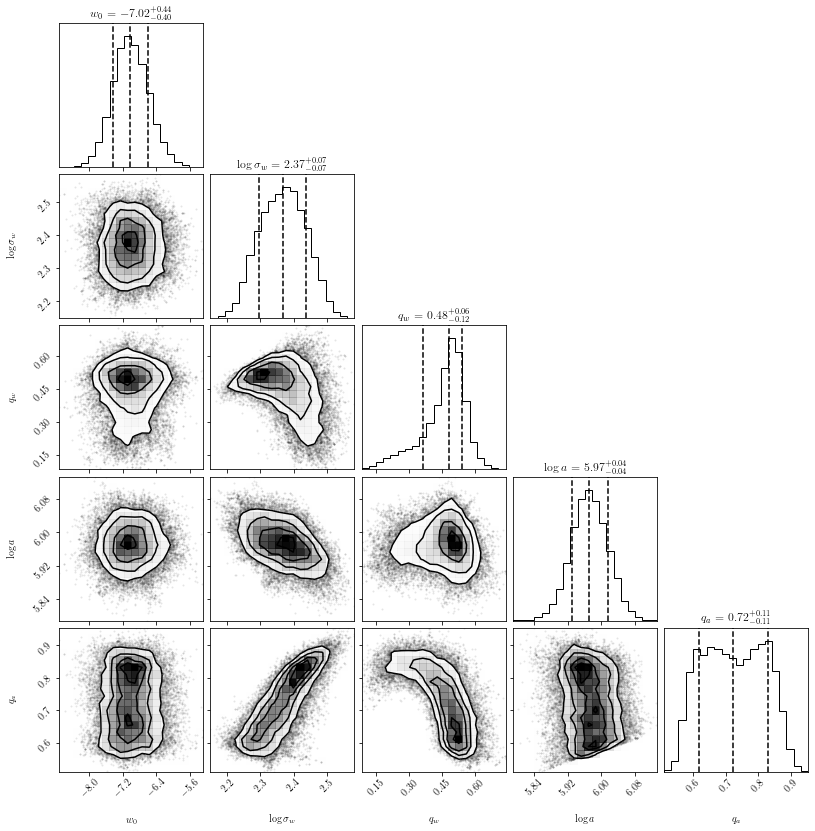

In [10]:
bs = {
    Model.DM.name: 6,
    Model.DDDM.name: 8,
    Model.NO.name: 5
}

b = bs[model.name]

# z
plot_corner(
    params=params[:, :, :b],
    labels=labels[:b],
)

# w
plot_corner(
    params=params[:, :, b:],
    labels=labels[b:],
)

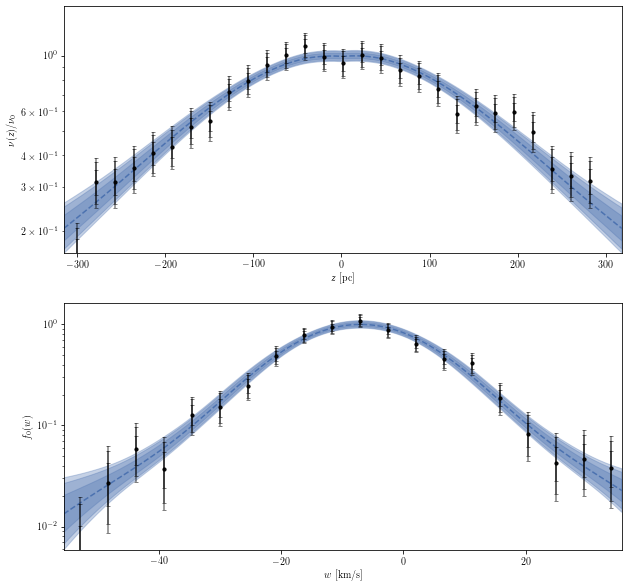

In [11]:
ndim = chain_thin.shape[-1]
flat_chain = chain_thin.reshape(-1, ndim)
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
# flat_chains.shape
plot_fit(
    model=model,
    flat_chain=flat_chain,
    zdata=zdata,
    wdata=wdata,
    log=True,
    nsample=10_000,
    res=100
)

In [76]:
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

log_bf_dm = bayes_factor(
    model=model, 
    flat_chain=flat_chain, 
    zdata=zdata,
    wdata=wdata,
    nsample=flat_chain.shape[0],
    batch=10
)
log_bf_dm

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


(-85.4040962153305, 0.04412151267218542)

In [77]:
def bic_aic(
        model: Model, 
        flat_chain: np.ndarray, 
        zdata,
        wdata,
        **options: dict
    ):
    """
    Calculate the bayes factor of the model
    """
    batch = options.get("batch", 10)
    
    length, ndim = flat_chain.shape
    theta = flat_chain

    zmid, znum, comp = zdata
    wmid, wnum = wdata
    log_nu0_max = np.log(znum.max())
    log_a_max = np.log(wnum.max())
    init = generate_init(model, log_nu0_max, log_a_max)
    locs = init['locs']
    scales = init['scales']    
    log_prob = np.log10(np.e)*model.log_prob_par(theta, zdata, wdata, locs, scales, batch=batch)
    log_likelihood = log_prob[:, 1]
    log_max = np.max(log_likelihood)
    bic = -2*log_max + ndim*np.log10(len(zmid)*3)
    aic = -2*log_max + 2*ndim
    return bic, aic

In [78]:
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

bic_dm, aic_dm = bic_aic(
    model=model, 
    flat_chain=flat_chain, 
    zdata=zdata,
    wdata=wdata,
    batch=10
)
bic_dm, aic_dm

(163.0561188806834, 170.37712761802317)

In [79]:
flat_chain = chain_thin.reshape(-1, ndim)
nsample = flat_chain.shape[0]
ndim = chain_thin.shape[-1]
zdata = get_data_z(z_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) > 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

probs_dm = predictive_posterior(
    model=model,
    flat_chain=flat_chain,
    zdata=zdata,
    nsample=nsample
)
np.sum(probs_dm*np.log10(np.e))

Calculating...


-21.55666072792645

## DDDM

In [80]:
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")
zdata_ori = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata_ori
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum= znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)
model = Model.DDDM
result = mcmc(
    model=model,
    zdata=zdata,
    wdata=wdata,
    step0=500,
    step=1000,
    burn=500,
    it=2,
    thin=10,
    m=10
)

result.keys()

running...
mcmc...
(474, 35)


mcmc:   0%|          | 0/2 [00:00<?, ?it/s]

0: first half mcmc done 13.4 s


mcmc:  50%|█████     | 1/2 [00:23<00:23, 23.21s/it]

0: second half mcmc done 9.69 s
1: first half mcmc done 9.12 s


mcmc: 100%|██████████| 2/2 [00:41<00:00, 21.00s/it]

1: second half mcmc done 9.59 s
burn done 9.11 s
mcmc done 17.41 s

dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [81]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels_raw = result['labels']
step, nwalker, ndim = chain_thin.shape
step, nwalker, ndim

(100, 350, 35)

100%|██████████| 13/13 [00:01<00:00,  7.04it/s]


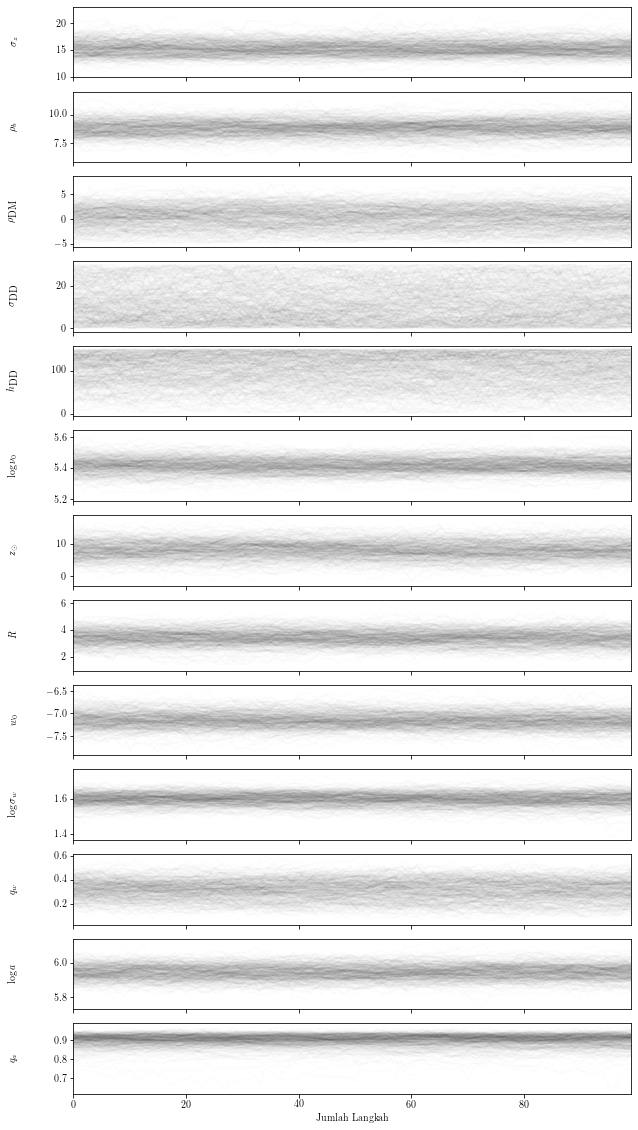

In [82]:
params, labels = get_params(chain_thin, indexes, labs, labels_raw)

plot_chain(
    params=params,
    labels=labels,
    alpha=0.01,
    figsize=(10, 20),
)

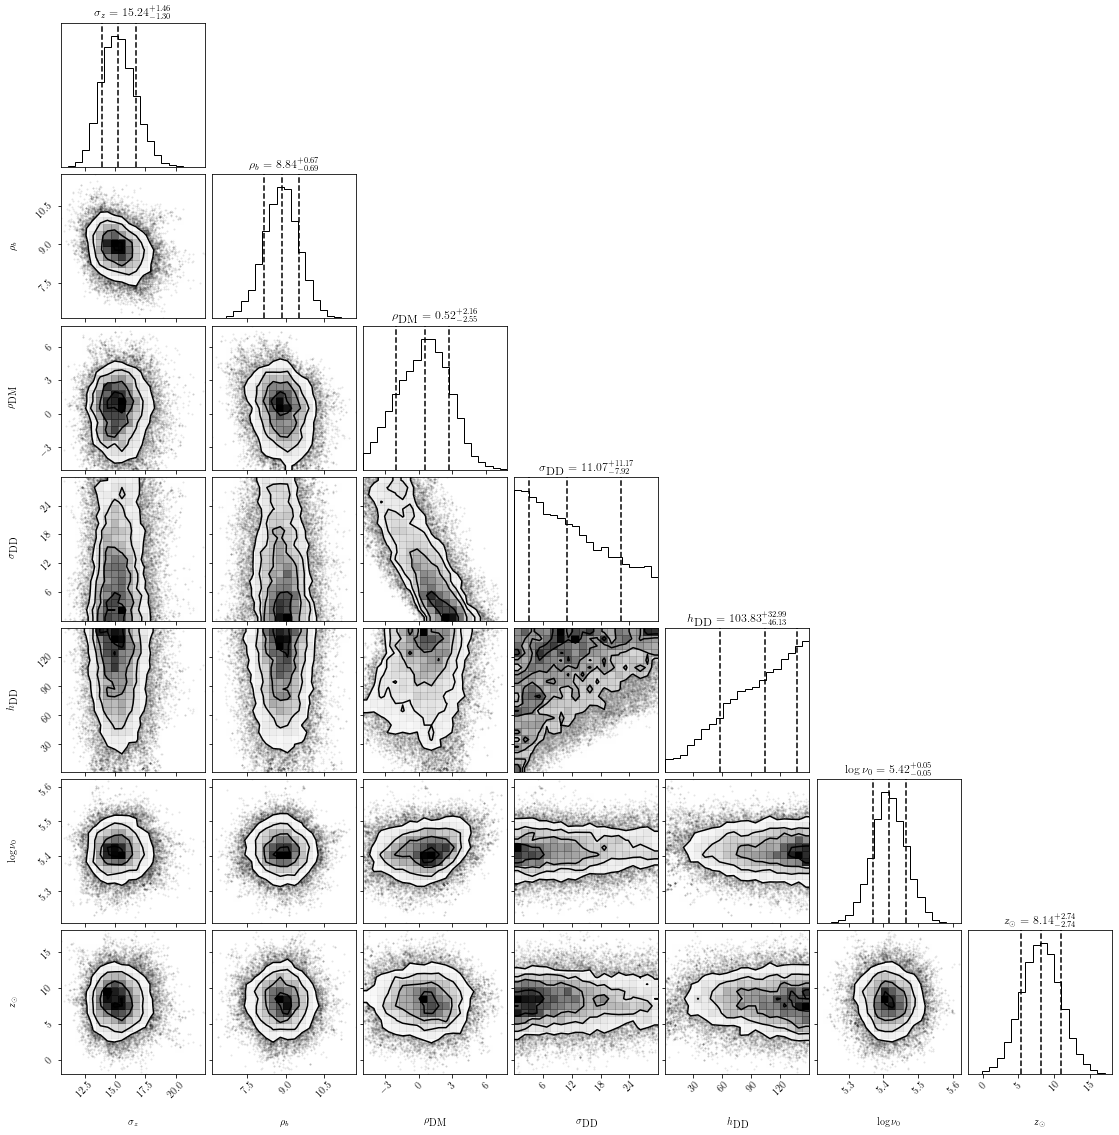

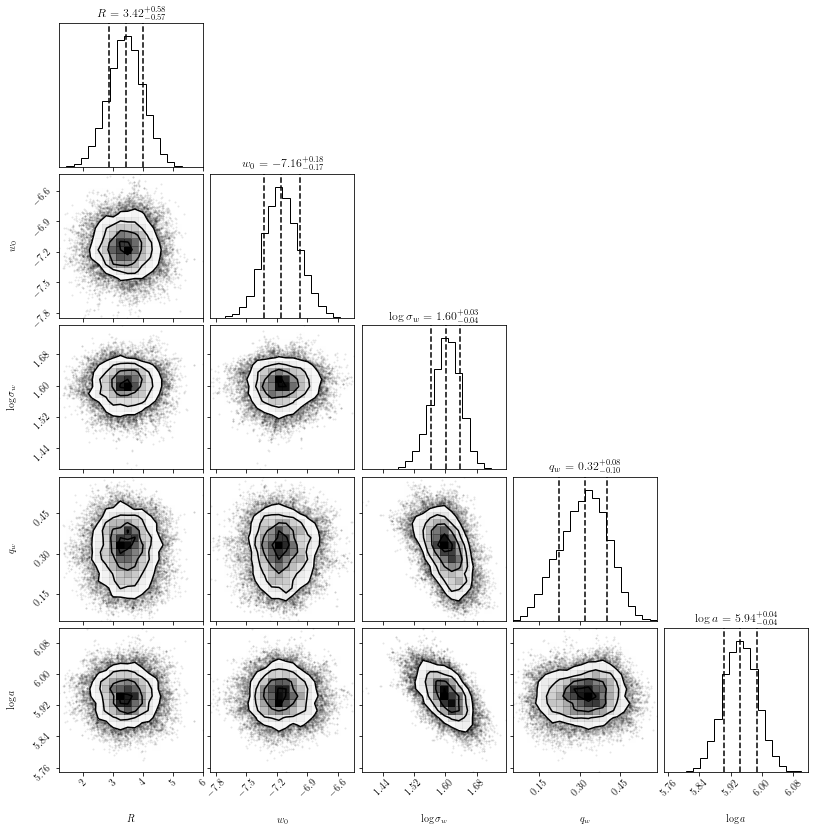

In [83]:
bs = {
    Model.DM.name: 5,
    Model.DDDM.name: 7,
    Model.NO.name: 4
}

b = bs[model.name]

# z
plot_corner(
    params=params[:, :, :b],
    labels=labels[:b],
)

# w
plot_corner(
    params=params[:, :, b:],
    labels=labels[b:],
)

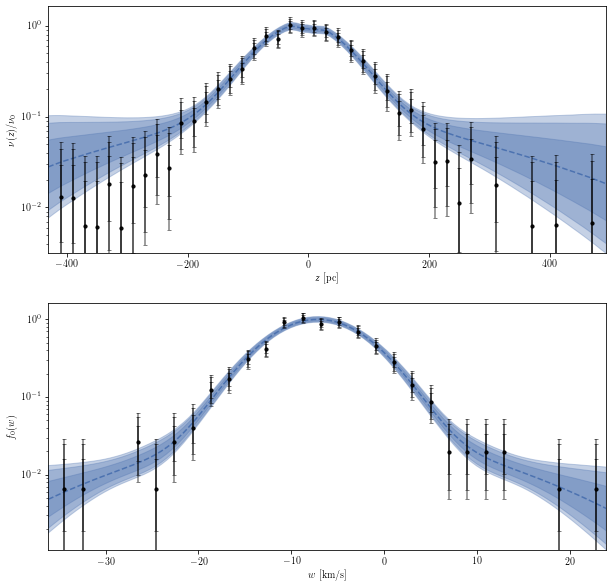

In [84]:
ndim = chain_thin.shape[-1]
flat_chain = chain_thin.reshape(-1, ndim)
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])

plot_fit(
    model=model,
    flat_chain=flat_chain,
    zdata=zdata,
    wdata=wdata,
    log=True,
    nsample=10_000,
    res=100
)

In [85]:
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

log_bf_dddm = bayes_factor(
    model=model, 
    flat_chain=flat_chain, 
    zdata=zdata,
    wdata=wdata,
    nsample=flat_chain.shape[0],
    batch=10
)
log_bf_dddm

100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


(-81.88778610610763, 0.11362418970037325)

In [86]:
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

bic_dddm, aic_dddm = bic_aic(
    model=model, 
    flat_chain=flat_chain, 
    zdata=zdata,
    wdata=wdata,
    batch=10
)
bic_dddm, aic_dddm

(166.6596974806248, 174.42440371719726)

In [87]:
flat_chain = chain_thin.reshape(-1, ndim)
nsample = flat_chain.shape[0]
ndim = chain_thin.shape[-1]
zdata = get_data_z(z_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) > 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

probs_dddm = predictive_posterior(
    model=model,
    flat_chain=flat_chain,
    zdata=zdata,
    nsample=nsample
)
np.sum(probs_dddm*np.log10(np.e))

Calculating...


-23.147176289895178

# NO

In [12]:
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")
zdata_ori = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata_ori
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)
model = Model.NO
result = mcmc(
    model=model,
    zdata=zdata,
    wdata=wdata,
    step0=500,
    step=1000,
    burn=500,
    it=2,
    thin=10,
    m=10
)

result.keys()

running...
mcmc...
(440, 32)


mcmc:   0%|          | 0/2 [00:00<?, ?it/s]

0: first half mcmc done 12.92 s


mcmc:  50%|█████     | 1/2 [00:22<00:22, 22.74s/it]

0: second half mcmc done 9.72 s
1: first half mcmc done 9.63 s


mcmc: 100%|██████████| 2/2 [00:42<00:00, 21.07s/it]

1: second half mcmc done 9.71 s
burn done 10.37 s
mcmc done 19.19 s


dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [13]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels_raw = result['labels']
step, nwalker, ndim = chain_thin.shape
step, nwalker, ndim

(100, 320, 32)

100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


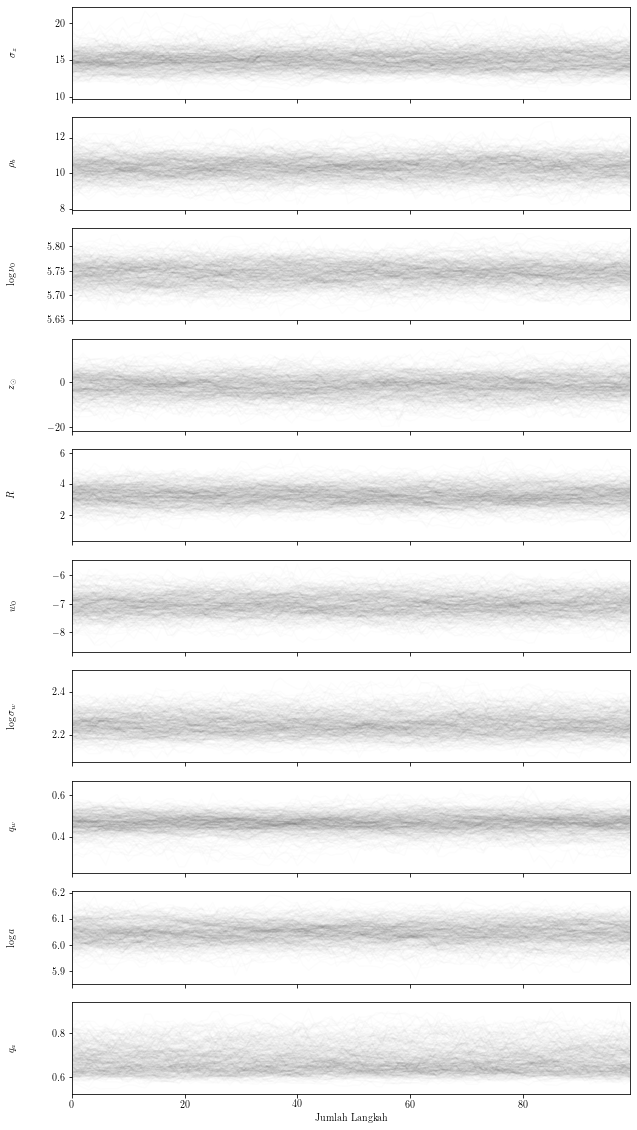

In [14]:
params, labels = get_params(chain_thin, indexes, labs, labels_raw)

plot_chain(
    params=params,
    labels=labels,
    alpha=0.01,
    figsize=(10, 20),
)

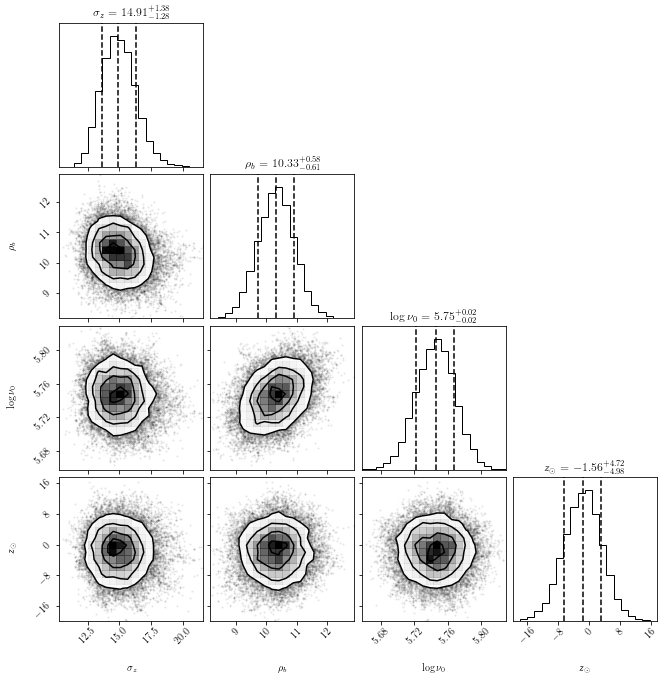

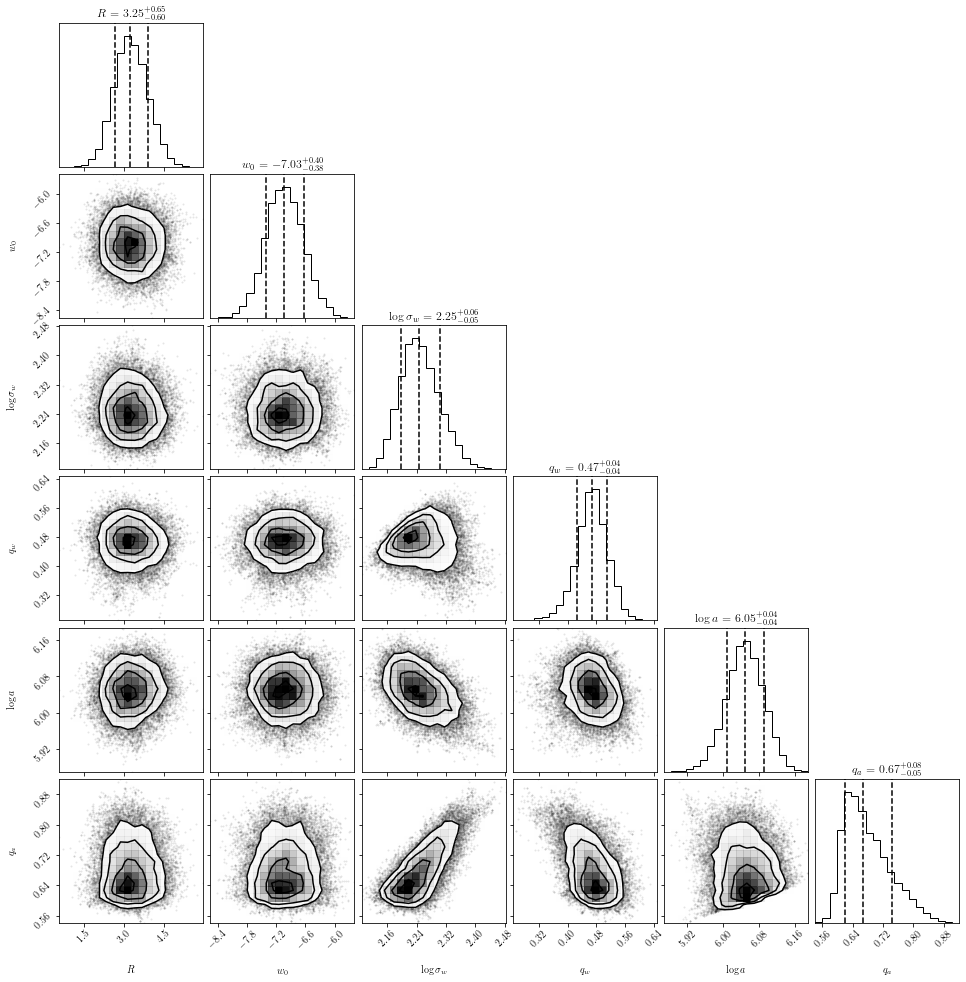

In [15]:
bs = {
    Model.DM.name: 5,
    Model.DDDM.name: 7,
    Model.NO.name: 4
}
# Model.DM.name
b = bs[model.name]

# z
plot_corner(
    params=params[:, :, :b],
    labels=labels[:b],
)

# w
plot_corner(
    params=params[:, :, b:],
    labels=labels[b:],
)

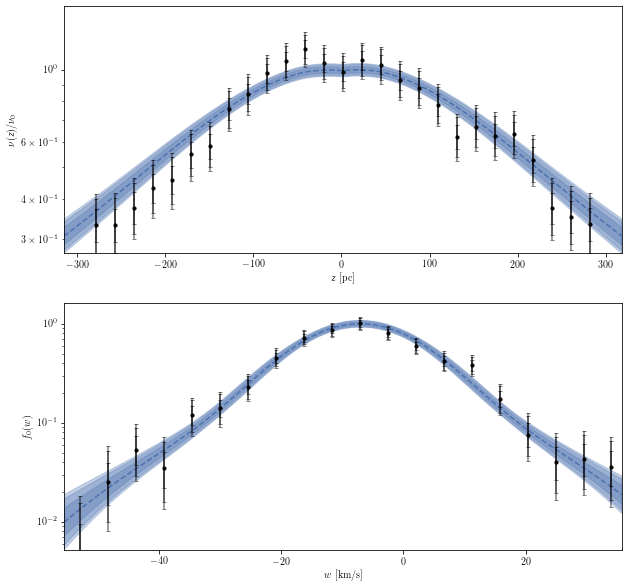

In [16]:
ndim = chain_thin.shape[-1]
flat_chain = chain_thin.reshape(-1, ndim)
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
# flat_chains.shape
plot_fit(
    model=model,
    flat_chain=flat_chain,
    zdata=zdata,
    wdata=wdata,
    log=True,
    nsample=10_000,
    res=100
)

In [93]:
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

log_bf_no = bayes_factor(
    model=model, 
    flat_chain=flat_chain, 
    zdata=zdata,
    wdata=wdata,
    nsample=flat_chain.shape[0],
    batch=10
)
log_bf_no

 20%|██        | 2/10 [00:00<00:03,  2.43it/s]

100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


(-85.67651956160523, 0.06396662065203244)

In [94]:
zdata = get_data_z(z_files[index])
wdata = get_data_w(w_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) < 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

bic_no, aic_no = bic_aic(
    model=model, 
    flat_chain=flat_chain, 
    zdata=zdata,
    wdata=wdata,
    batch=10
)
bic_no, aic_no

(161.73835068593164, 168.83751067365503)

In [95]:
flat_chain = chain_thin.reshape(-1, ndim)
nsample = flat_chain.shape[0]
ndim = chain_thin.shape[-1]
zdata = get_data_z(z_files[index])
zmid, znum, comp = zdata
mask = np.abs(zmid) > 200
zmid = zmid[mask]
znum = znum[mask]
comp = comp[mask]
zdata = (zmid, znum, comp)

probs_no = predictive_posterior(
    model=model,
    flat_chain=flat_chain,
    zdata=zdata,
    nsample=nsample
)
np.sum(probs_dddm*np.log10(np.e))

Calculating...


-23.147176289895178

# comp predictive

In [96]:
zdata[0]

array([-410., -390., -370., -350., -330., -310., -290., -270., -250.,
       -230., -210.,  210.,  230.,  250.,  270.,  310.,  370.,  410.,
        470.])

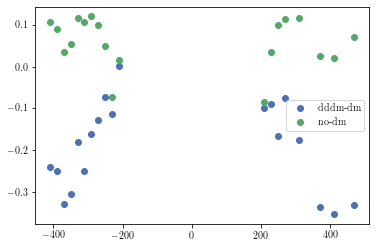

In [97]:
diff_dddm_dm = probs_dddm - probs_dm
diff_no_dm = probs_no - probs_dm

plt.scatter(zdata[0], diff_dddm_dm, label="dddm-dm")
plt.scatter(zdata[0], diff_no_dm, label="no-dm")
plt.legend()
plt.show()

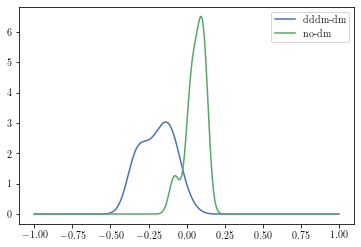

In [99]:
# fit kde to diff

from scipy.stats import gaussian_kde

kde_dddm_dm = gaussian_kde(diff_dddm_dm)
kde_no_dm = gaussian_kde(diff_no_dm)

x = np.linspace(-1, 1, 1000)
plt.plot(x, kde_dddm_dm(x), label="dddm-dm")
plt.plot(x, kde_no_dm(x), label="no-dm")
plt.legend()    
plt.show()

In [100]:
p_dm = np.sum(probs_dm*np.log10(np.exp(1)))
p_dddm = np.sum(probs_dddm)*np.log10(np.exp(1))
p_no = np.sum(probs_no*np.log10(np.exp(1)))
p_dm, p_dddm, p_no

(-21.55666072792645, -23.147176289895178, -21.069410540658453)

In [101]:
p_no - p_dm, p_dddm - p_dm

(0.4872501872679962, -1.5905155619687292)